<div style="width: 100%; overflow: hidden;">
    <div style="width: 150px; float: left;"> <img src="data/D4Sci_logo_ball.png" alt="Data For Science, Inc" align="left" border="0" width=150px> </div>
    <div style="float: left; margin-left: 10px;"><h1>Bitcoin Transaction Network</h1>
<h1>Networks on the Blockchain</h1>
        <a href="http://www.data4sci.com/">www.data4sci.com</a><br/>
            @bgoncalves, @data4sci</p></div>
</div>

In [1]:
from collections import Counter
from pprint import pprint

import os
import random

import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt 

import tqdm as tq
from tqdm import tqdm
import dataframe_image as dfi

tqdm.pandas()

import networkx as nx

import watermark

%load_ext watermark
%matplotlib inline

We start by print out the versions of the libraries we're using for future reference

In [2]:
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 20.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

Git hash: 8140f0ef054e80da0b468b7e9e86b85c87a015f1

json           : 2.0.9
pandas         : 1.2.2
dataframe_image: 0.1.1
watermark      : 2.1.0
matplotlib     : 3.3.2
numpy          : 1.20.1
networkx       : 2.5
tqdm           : 4.50.2



Load default figure style

In [3]:
plt.style.use('./d4sci.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Load transaction inputs and outputs

Each transaction can have an arbitrary number of inputs and outputs. The inputs for one transaction are the numered outputs of another, with the outputs are wallet addresses. Out dataset makes our lives a bit easier by mapping the transaction inputs to individual addresses as well.

In [4]:
txin = pd.read_csv('data/txin.txt.gz', sep=' ', header=None, 
                names=['txid', 'addrID_in', 'value_in'], 
                   dtype={'value_in': 'int64', 'addrID_in': 'str',
                          'txid': 'str'}
                  ).sort_values('txid')
txout = pd.read_csv('data/txout.txt.gz', sep=' ', header=None, 
                names=['txid', 'addrID_out', 'value_out'], 
                   dtype={'value_out': 'int64', 'addrID_out': 'str',
                          'txid': 'str'}
                   ).sort_values('txid')

Save the images of the dataframes

In [5]:
dfi.export(txin.head(), 'txin.png')
txin.head()

,txid,addrID_in,value_in
811449,101107045,26975401,1949990000
1942625,101107046,64015289,12500000
1754780,101107047,57756609,2900000
1337226,101107048,43773546,5800000
1263425,101107049,41410645,9457394


In [6]:
dfi.export(txout.head(), 'txout.png')
txout.head()

,txid,addrID_out,value_out
2917664,101107044,92941637,2522206709
438287,101107045,14482566,160772600
1574551,101107045,50151625,1788817400
2832733,101107046,90097048,12400000
54546,101107047,1867036,2800000


We also create a dict of Transaction IDs to hashs:

In [7]:
trans_dict = dict(pd.read_csv('data/txhash.txt.gz', sep=' ', header=None, 
                              names=['txid', 'txhash'], dtype='str').values)

Since we're mapping to addresses, we compute the total values by input/output. These will come in handy later

In [8]:
total_in = txin[['txid', 'value_in']].groupby(['txid']).sum()
total_out = txout[['txid', 'value_out']].groupby(['txid']).sum()

Now we match input and output values

In [9]:
totals = total_in.join(total_out, how='inner')

The fee paid by a transaction is the difference between the input and output values

In [10]:
totals['fee'] = totals['value_in'] - totals['value_out']

And can be fairly large

In [11]:
totals.sort_values('fee', ascending=False).head()

,value_in,value_out,fee
txid,,,
102275040,4800091956,4720271956,79820000
101763142,735605245,695605245,40000000
101762081,483589254,463589254,20000000
102149798,476206572,456206572,20000000
101820675,249069179,233069179,16000000


Now we join the inputs and outputs for each transaction

In [12]:
trans = txin.merge(txout, on='txid').set_index('txid')

In [13]:
trans.head()

,addrID_in,value_in,addrID_out,value_out
txid,,,,
101107045,26975401,1949990000,14482566,160772600
101107045,26975401,1949990000,50151625,1788817400
101107046,64015289,12500000,90097048,12400000
101107047,57756609,2900000,1867036,2800000
101107048,43773546,5800000,46562047,5700000


We have over 14 million rows in our full dataframe

In [14]:
trans.shape

(14181316, 4)

Let's look at a specific transaction

In [15]:
trans_ex = trans.loc['101240012'].sort_values('value_out')

Here we have 8 inputs and 1 output, so it's pretty clear we get 8 edges

In [16]:
trans_ex

,addrID_in,value_in,addrID_out,value_out
txid,,,,
101240012,92973567,666222,100727977,7043791
101240012,82605258,1375212,100727977,7043791
101240012,85111997,162710,100727977,7043791
101240012,82605258,1390000,100727977,7043791
101240012,83358190,1315405,100727977,7043791
101240012,417,477380,100727977,7043791
101240012,8122206,904655,100727977,7043791
101240012,58313199,812207,100727977,7043791


We can also look up this transaction online. The hash of the transaction is:

In [17]:
trans_dict['101240012'].lower()

'cbd79d3e8dffb3f41afb69e77a4e4b6122d125387a42674de4c941c3e74c0363'

Which we can easily find online

[![alt text](blockchain.png "Block")](https://www.blockchain.com/btc/tx/CBD79D3E8DFFB3F41AFB69E77A4E4B6122D125387A42674DE4C941C3E74C0363)

Let's consider another example

In [18]:
trans_ex2 = trans.loc['101107060'].sort_values('value_out')

Here we have 2 inputs and 2 outputs, so we get 4 edges

In [19]:
trans_ex2

,addrID_in,value_in,addrID_out,value_out
txid,,,,
101107060,58700630,523000,3203331,1000615
101107060,67593721,15277615,3203331,1000615
101107060,58700630,523000,110812190,14700000
101107060,67593721,15277615,110812190,14700000


But since the value_in/value_out are just repeated how do we ajust them to specify how much, say, addrID_in 58700630 sends to addID_out 3203331? Each transaction works as a mixer so we just divide them evenly

In [20]:
trans_ex2['value_in'] = (trans_ex2['value_in']/total_in.loc['101107060'].sum()*trans_ex2['value_out'])

And we can easily check that the weights sum up to the total output value

In [21]:
trans_ex2['value_in'].sum()

15700615.0

And comparing

In [22]:
total_out.loc['101107060']

value_out    15700615
Name: 101107060, dtype: int64

So we finally recover the edges of our address network for this transaction

In [23]:
dfi.export(trans_ex[['addrID_in', 'addrID_out', 'value_in']], 'trans_ex.png')
trans_ex[['addrID_in', 'addrID_out', 'value_in']]

,addrID_in,addrID_out,value_in
txid,,,
101240012,92973567,100727977,666222
101240012,82605258,100727977,1375212
101240012,85111997,100727977,162710
101240012,82605258,100727977,1390000
101240012,83358190,100727977,1315405
101240012,417,100727977,477380
101240012,8122206,100727977,904655
101240012,58313199,100727977,812207


so we apply this transformation to all transactions in our dataset. This takes a while, so we cache the result

In [24]:
if not os.path.exists('data/transaction_edges.txt.gz'):
    def extract_edges(tx):
        txid = tx['txid'].iloc[0]

        tx['value_in'] = (tx['value_in']/total_in.loc[txid].sum()*tx['value_out'])
        return tx[['txid', 'addrID_in', 'addrID_out', 'value_in']]    
    
    trans_edges = trans.reset_index().groupby('txid').progress_apply(extract_edges)
    trans_edges.to_csv('data/transaction_edges.txt.gz', header=True, index=False)
else:
    trans_edges = pd.read_csv('data/transaction_edges.txt.gz')

And now we have a total of over 10 million edges

In [25]:
edges = trans_edges[
    ['addrID_in', 'addrID_out', 'value_in']
].groupby(['addrID_in', 'addrID_out'], as_index=False).sum()

In [26]:
edges.shape

(10314275, 3)

Connecting over 2.5 million individual addresses

In [27]:
len(set(edges.addrID_in) | set(edges.addrID_out))

2505841

# Wallets

One aspect of the transactions that not imediately appearent is that, while inputs can come from multiple addresses, the person performing the transaction must posess the private keys for each of them. In practice, this means that the addresses that share a common transaction all belong to the same person and can be grouped into wallets idendifying individual entities.

We start by generating edges connecting all the addresses that are inputs to the same transaction. In this way we create a graph where each weakly connected component contains all the addresses controled by a single individual (or institution).

In [28]:
edges = set()
txid = None

for row in tqdm(txin.itertuples(index=False), total=txin.shape[0]):
    if row.txid == txid:
        edges.add((row.addrID_in, oldAddr))
        
    oldAddr = row.addrID_in
    txid = row.txid

100%|██████████| 4059646/4059646 [00:05<00:00, 782153.11it/s]


In total we have just over 1.9M unique edges connecting addresses

In [29]:
len(edges)

1821415

Now we use the same function we defined previously to identify each of the connected components

In [30]:
def weakly_connected_components(edges):
    nodes = {}
    components = {}
    component_count = 0

    for node_i, node_j in tqdm(edges, total=len(edges)):
        # Both nodes are new
        if node_i not in nodes and node_j not in nodes:
            nodes[node_i] = component_count
            nodes[node_j] = component_count
            components[component_count] = set([node_i, node_j])
            component_count += 1

        # Both nodes have already been seen
        elif node_i in nodes and node_j in nodes:
            component_i = nodes[node_i]
            component_j = nodes[node_j]

            # Nothing to do
            if component_i == component_j:
                continue
            else:
                keep, remove = (component_i, component_j) if \
                component_j > component_i else (component_j, component_i)

                components[keep] |= components[remove]
                for node in components[remove]:
                    nodes[node] = keep

                del components[remove]

        # Node_j is new
        elif node_i in nodes and node_j not in nodes:
            component_i = nodes[node_i]
            nodes[node_j] = component_i
            components[component_i].add(node_j)

        # Node_i is new
        elif node_j in nodes and node_i not in nodes:
            component_j = nodes[node_j]
            nodes[node_i] = component_j
            components[component_j].add(node_i)
   
    return list(components.values())

In [31]:
components = weakly_connected_components(edges)

100%|██████████| 1821415/1821415 [00:04<00:00, 374071.86it/s]


resulting in 382k components

In [32]:
len(components)

382681

We can easily compute the size of each compartment

In [33]:
comp_sizes = [len(comp) for comp in components]

In total we have 1.6M individual addresses assigned to clusters. This is a subset of the total number of addresses in our dataset as we are not counting "unspent transaction outputs", outputs from transactions that haven't been spent yet

In [34]:
sum(comp_sizes)

1648014

And we can also compute the distribution of component sizes

In [35]:
Ns = Counter(comp_sizes)
Ns = pd.DataFrame(sorted(Ns.items(), key=lambda x: x[0]), columns=['s', 'Ns'])

Which we can plot on a logarithmic scale

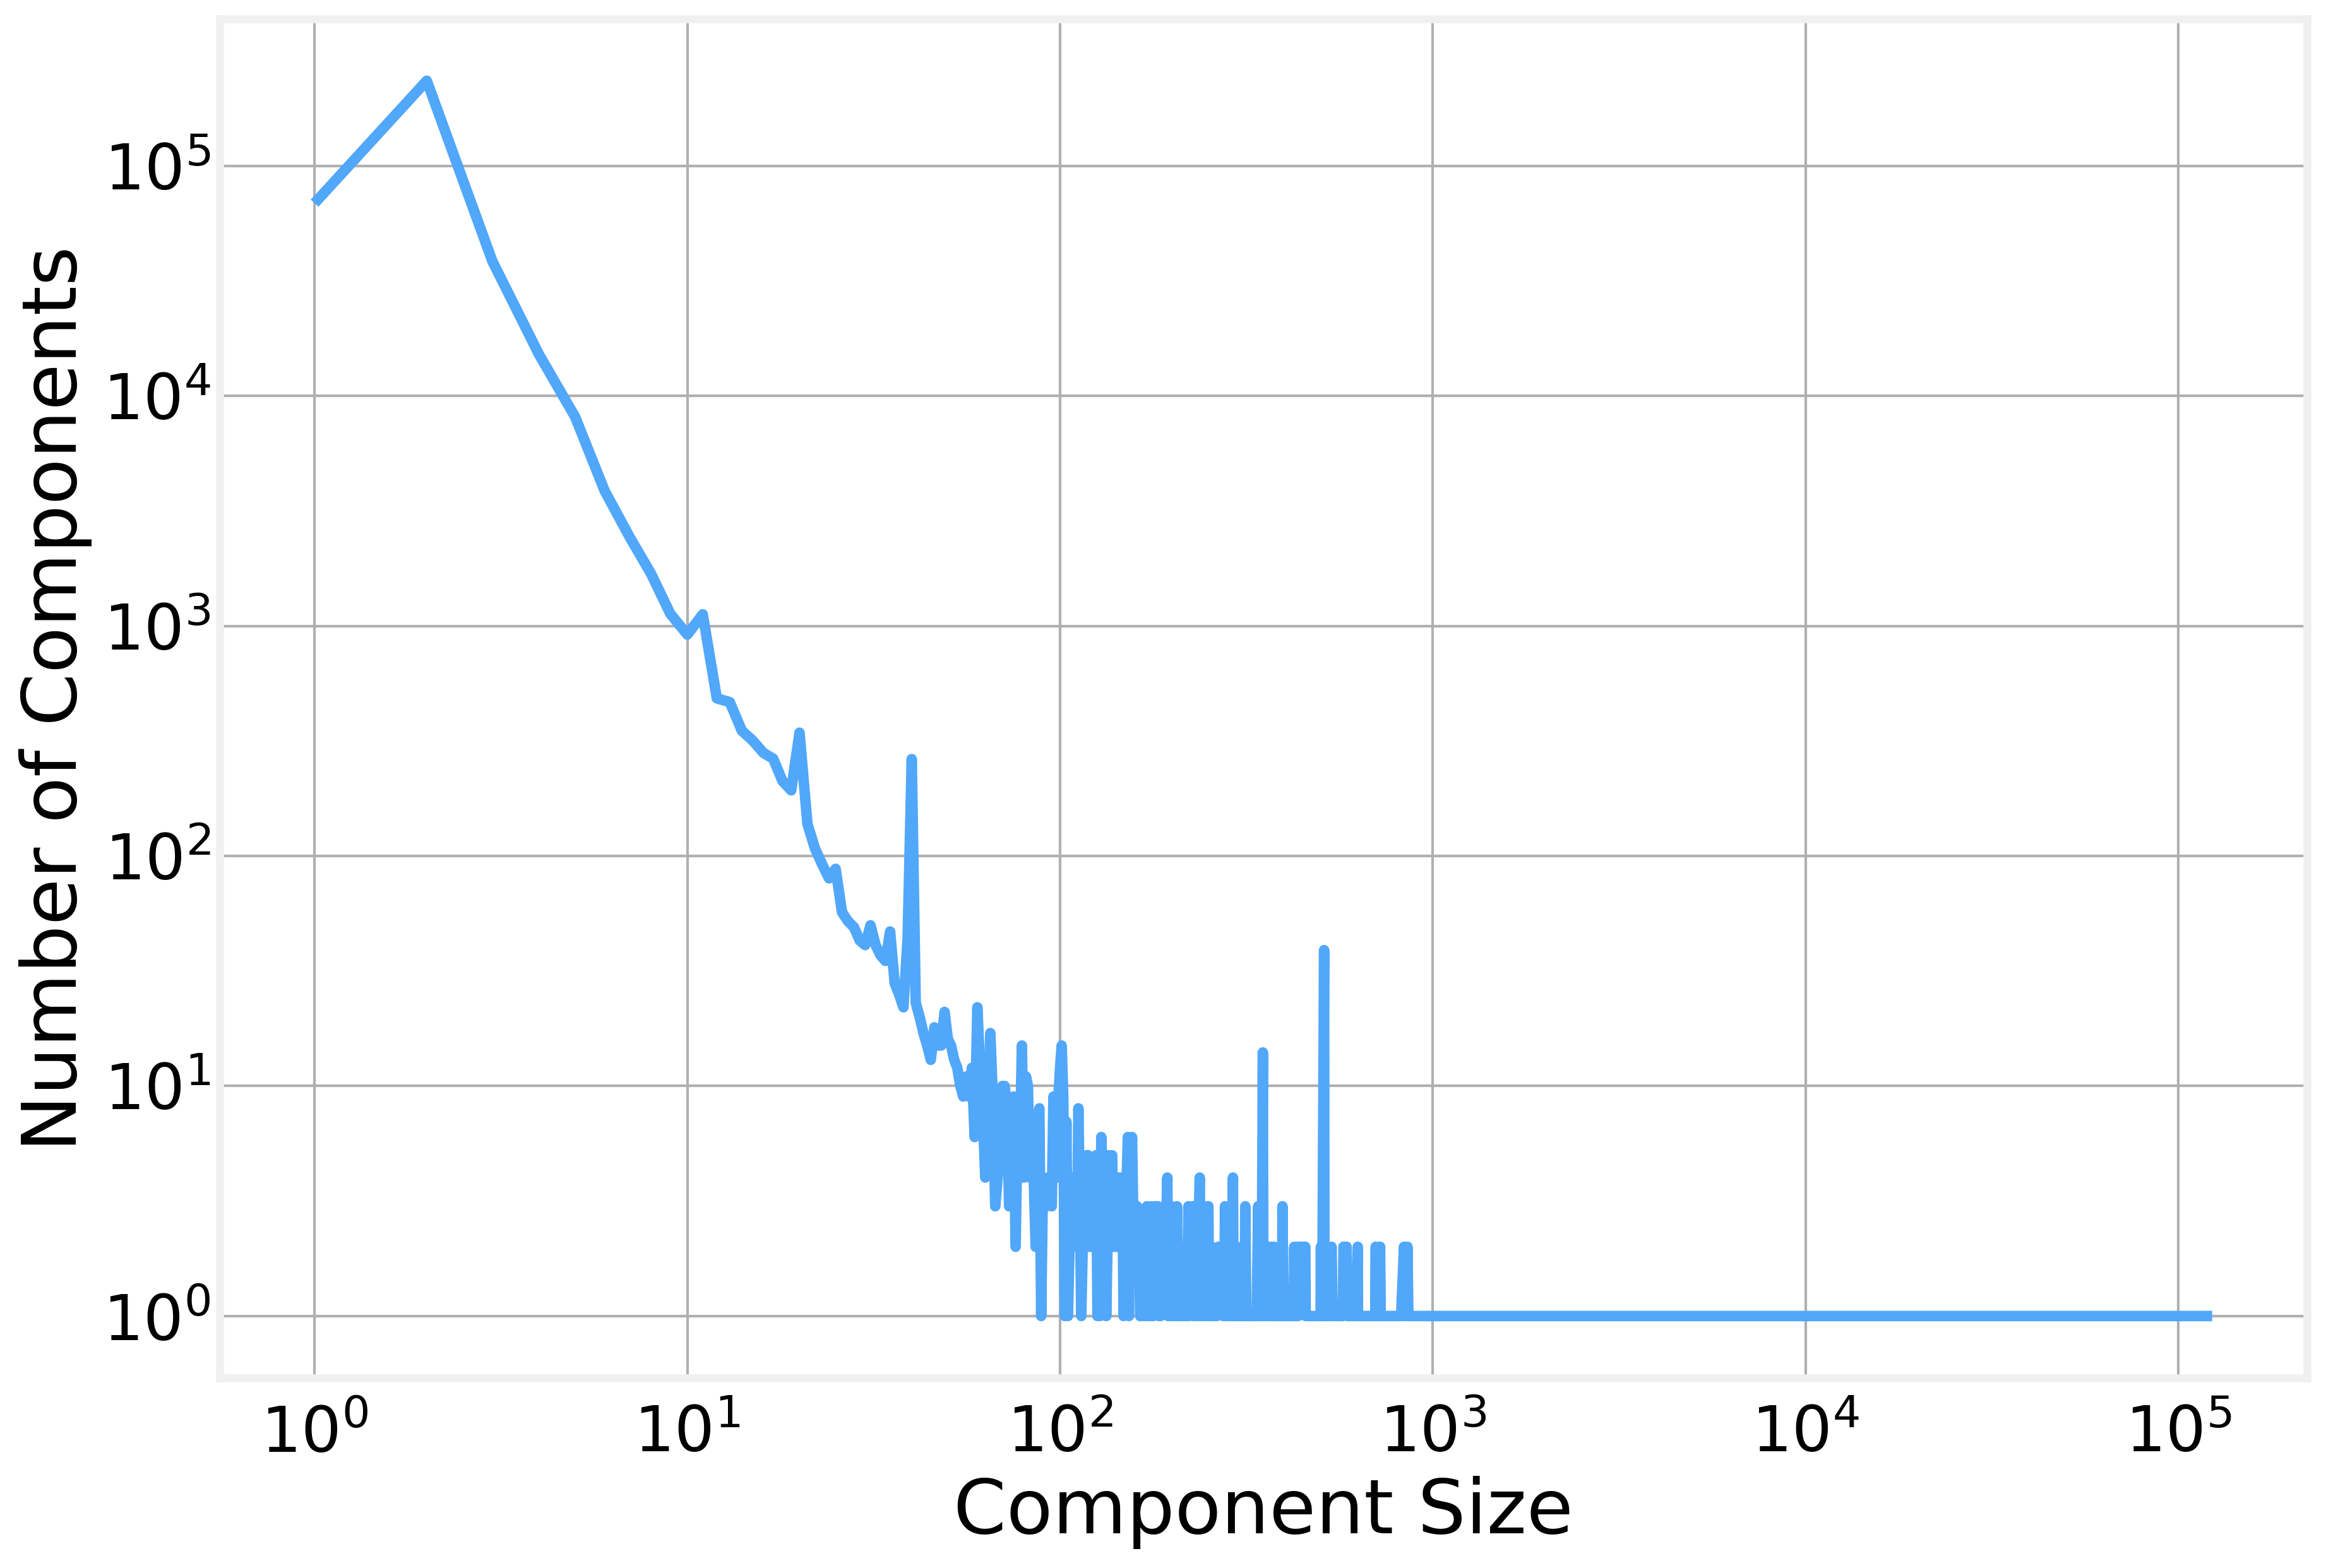

In [36]:
ax = Ns.plot(x='s', y='Ns', legend=None)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Number of Components')
ax.set_xlabel('Component Size')
ax.tick_params(axis='x', which='major', pad=10)

The largest components accounts for an astonishing 123,285 addresses, almost 10x as many as the second largest component

In [37]:
Ns.tail()

,s,Ns
512,9640,1
513,14684,1
514,15014,1
515,18769,1
516,123285,1


While 50% of the addresses belong to clusters of size 10 or smaller

In [38]:
Ns['Naddresses'] = np.cumsum(Ns.s*Ns.Ns)
Ns['Naddresses']/=Ns['Naddresses'].max()

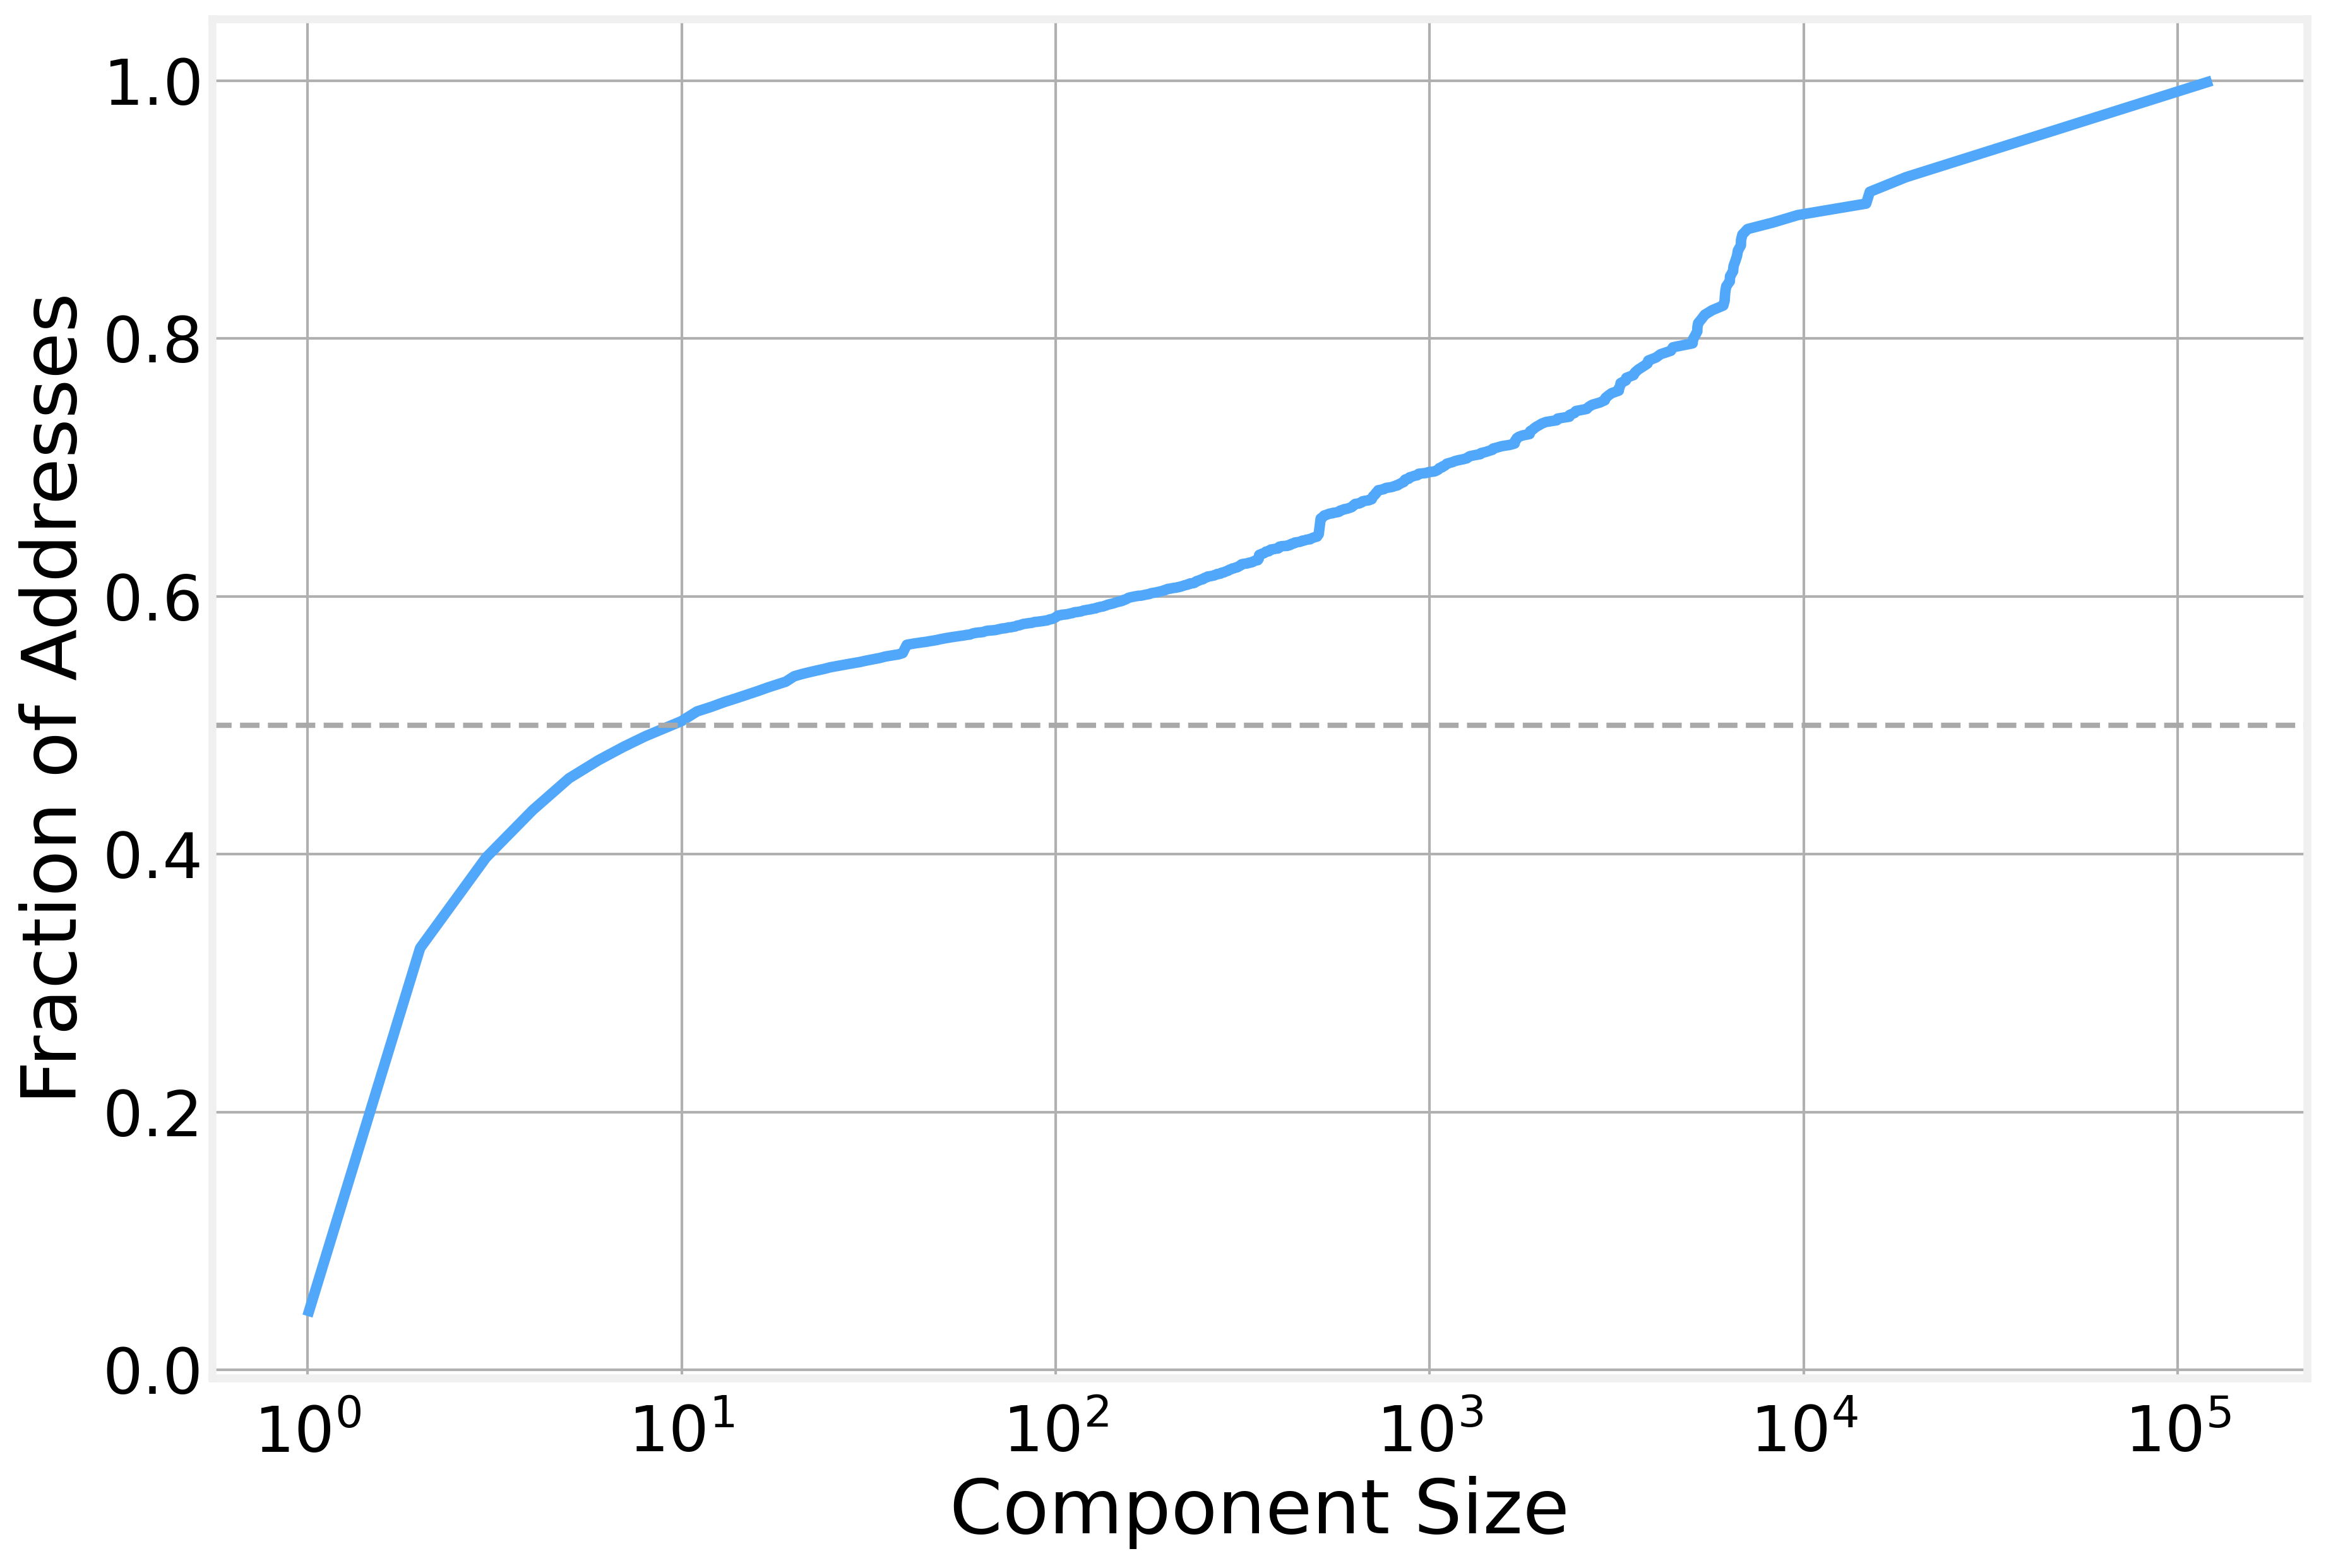

In [39]:
ax = Ns.plot(x='s', y='Naddresses', legend=None)
ax.set_ylabel('Fraction of Addresses')
ax.set_xlabel('Component Size')
ax.set_xscale('log')
ax.axhline(y=0.5, lw=2, linestyle='--', color='darkgray')
ax.tick_params(axis='x', which='major', pad=10)

<div style="width: 100%; overflow: hidden;">
     <img src="data/D4Sci_logo_full.png" alt="Data For Science, Inc" align="center" border="0" width=300px> 
</div>